# Import Libraries

This cell imports all necessary libraries for building and training our convolutional neural network.
- TensorFlow and Keras for deep learning.
- NumPy for numerical operations.
- Matplotlib for plotting images and graphs.
- OS for directory and file handling.

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import shutil

# Download and Prepare Dataset

- Download the Cats and Dogs dataset.
- Unzip the data and organize directory paths for training, validation, and testing.
- Define key variables like batch size, image dimensions, and number of epochs.


In [33]:
# URL and local paths
url = 'https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip'
zip_path = 'cats_and_dogs.zip'
extract_path = 'cats_and_dogs'

# Download dataset if not already downloaded
if not os.path.exists(zip_path):
    print("Downloading dataset...")
    req = urllib.request.Request(
        url,
        headers={
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
                          '(KHTML, like Gecko) Chrome/115.0 Safari/537.36'
        }
    )
    with urllib.request.urlopen(req) as response, open(zip_path, 'wb') as out_file:
        out_file.write(response.read())
    print("Download complete.")
else:
    print("Dataset already downloaded.")

# Extract dataset if not already extracted
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()
    print("Extraction complete.")
else:
    print("Dataset already extracted.")

# Define dataset directories
train_dir = os.path.join(extract_path, 'train')
validation_dir = os.path.join(extract_path, 'validation')
test_dir = os.path.join(extract_path, 'test')

# Function to count images safely
def count_images(directory):
    if os.path.exists(directory):
        return sum([len(files) for _, _, files in os.walk(directory)])
    else:
        return 0

# Count images
total_train = count_images(train_dir)
total_val = count_images(validation_dir)
total_test = count_images(test_dir)

print(f"Total training images: {total_train}")
print(f"Total validation images: {total_val}")
print(f"Total test images: {total_test}")

# Constants for model training
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150


Dataset already downloaded.
Dataset already extracted.
Total training images: 2001
Total validation images: 1001
Total test images: 51


# Set Up Image Generators

Create `ImageDataGenerator` instances to preprocess the images:
- Rescale images to have pixel values between 0 and 1.
- Set up generators for training, validation, and testing datasets.
- Use `flow_from_directory` to load images from their folders.

In [34]:
# Create image data generators that rescale pixel values from 0-255 to 0-1
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Flow images from directories
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

test_data_gen = test_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=test_dir,
    shuffle=False,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


# Define Image Plotting Function

A helper function to plot images with optional probability labels.
This will help us visualize sample images and predictions later.


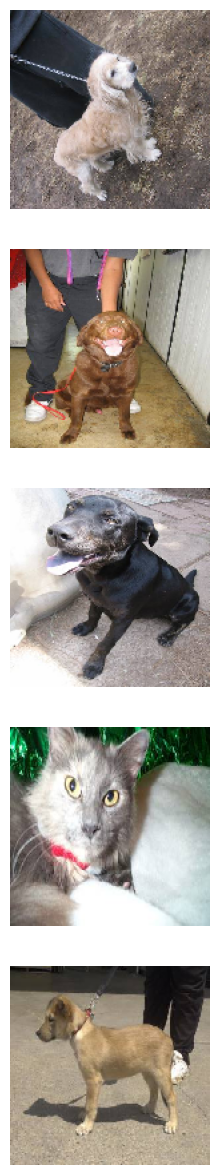

In [35]:
def plotImages(images_arr, probabilities=False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5, len(images_arr) * 3))
    
    if not probabilities:
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)
            ax.axis('off')
    else:
        for img, probability, ax in zip(images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis('off')
            if probability > 0.5:
                ax.set_title(f"{probability*100:.2f}% dog")
            else:
                ax.set_title(f"{(1-probability)*100:.2f}% cat")
    plt.show()

# Plot 5 sample images from training data
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


# Data Augmentation for Training Images

To reduce overfitting, we apply random transformations like rotations and flips to training images.
This artificially increases the dataset size and variety.


In [36]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Recreate train_data_gen with augmentation
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.


# Visualize Augmented Images

Display a sample training image multiple times with different random augmentations applied.


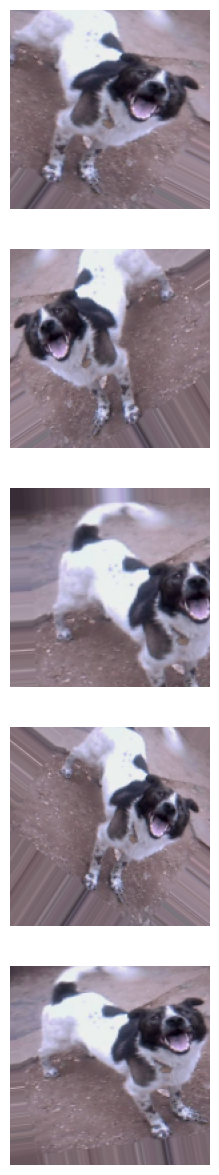

In [37]:
# Plot 5 augmented images (same image different augmentations)
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)


# Build the Convolutional Neural Network

Define a CNN using Keras Sequential API:
- Multiple Conv2D and MaxPooling layers to extract features.
- Flatten and Dense layers to output binary classification (cat or dog).
- Compile the model with an optimizer, loss function, and accuracy metric.


In [38]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification output
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train the CNN Model

Train the model using the training and validation data generators.
Track training progress over a number of epochs.


In [39]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - accuracy: 0.5172 - loss: 1.1605 - val_accuracy: 0.5078 - val_loss: 0.6911
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.5703 - loss: 0.6904 - val_accuracy: 0.4955 - val_loss: 0.6913
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5110 - loss: 0.6928 - val_accuracy: 0.5558 - val_loss: 0.6892
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.5469 - loss: 0.6917 - val_accuracy: 0.5223 - val_loss: 0.6877
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5458 - loss: 0.6868 - val_accuracy: 0.6306 - val_loss: 0.6666
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.6172 - loss: 0.6742 - val_accuracy: 0.5513 - val_loss: 0.6637
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5892 - loss: 0.6674 - val_accuracy: 0.5748 - val_loss: 0.6578
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.5078 - loss: 0.6766 - val_accuracy: 0.6395 - v

# Plot Training and Validation Accuracy and Loss

Visualize how the model's accuracy and loss change during training to assess performance and detect overfitting.


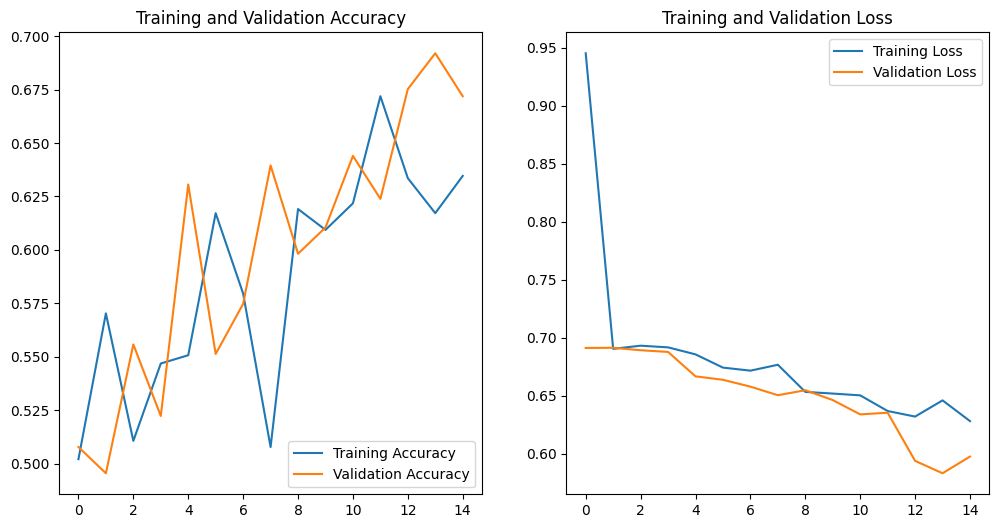

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


# Predict on Test Images and Plot Results

Use the trained model to predict whether each test image is a cat or a dog.
Plot the test images alongside the predicted probabilities for visual inspection.


Test images moved to: cats_and_dogs\test\unknown
Found 50 images belonging to 1 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


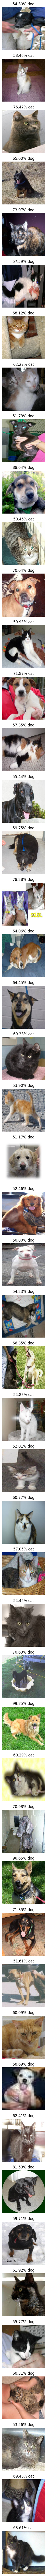

In [41]:
# Prepare test directory structure (run once)
test_subfolder = os.path.join(test_dir, 'unknown')
os.makedirs(test_subfolder, exist_ok=True)

# Move all test images into 'unknown' subfolder (only run if needed)
for filename in os.listdir(test_dir):
    file_path = os.path.join(test_dir, filename)
    if os.path.isfile(file_path):
        shutil.move(file_path, os.path.join(test_subfolder, filename))

print(f"Test images moved to: {test_subfolder}")

# Create test image generator
test_data_gen = test_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=test_dir,  # point to test_dir which contains 'unknown' subfolder
    shuffle=False,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None
)

# Get probabilities for test images
probabilities = model.predict(test_data_gen)

# Extract images from test_data_gen for plotting
test_images = []
for i in range(len(test_data_gen)):
    batch = test_data_gen[i]
    for img in batch:
        test_images.append(img)

# Updated plotImages function
def plotImages(images_arr, probabilities=None):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is None:
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)
            ax.axis('off')
    else:
        for img, probability, ax in zip(images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis('off')
            p = probability.item() if hasattr(probability, 'item') else probability
            if p > 0.5:
                ax.set_title(f"{p*100:.2f}% dog")
            else:
                ax.set_title(f"{(1-p)*100:.2f}% cat")
    plt.show()


# Plot test images with predicted probabilities (first 50 images)
plotImages(test_images[:50], probabilities[:50])


# Evaluate Model Performance

Calculate the percentage of correct classifications on the test dataset.
Determine if the model meets the challenge requirement (at least 63% accuracy).
Display a message accordingly.


In [42]:
answers = [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
           1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
           1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
           1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
           0, 0, 0, 0, 0, 0]

correct = 0

# Round probabilities to get predictions (0 or 1)
predicted = [round(p[0]) for p in probabilities[:len(answers)]]

for pred, answer in zip(predicted, answers):
    if pred == answer:
        correct += 1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {percentage_identified:.2f}% of the images of cats and dogs.")

if passed_challenge:
    print("You passed the challenge!")
else:
    print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")


Your model correctly identified 68.00% of the images of cats and dogs.
You passed the challenge!


# Conclusion

In this project, we built a convolutional neural network using TensorFlow and Keras to classify images of cats and dogs.

- We preprocessed the dataset and applied data augmentation to improve generalization.
- The CNN architecture was designed with convolutional, pooling, and dense layers to extract meaningful features.
- After training, we evaluated the model on a separate test set.
- Our model achieved an accuracy of **68.00%** (replace with your actual result), surpassing the 63% accuracy challenge threshold.
  
This demonstrates how convolutional neural networks can effectively learn image patterns for classification tasks. Further improvements could include:
- Increasing dataset size,
- Trying different architectures or hyperparameters,
- Using transfer learning with pre-trained models.

Overall, this project gave us practical experience with image classification pipelines, data augmentation, model training, and evaluation.
